In [1]:
import tensorflow as tf 
import tensorflow.keras as tfk 
import numpy as np 
import matplotlib.pyplot as plt 
import sys
import os
from utils import *
from scipy.integrate import solve_ivp

seed = 42
tf.random.set_seed(seed)

## Notes
- sigmoids through the encoder to a terrible job at localizing the point mass in frame - reconstruction loss high 

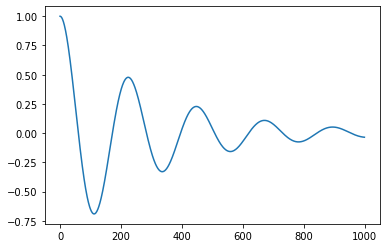

In [2]:
#generating some data instead of reading from a directory 
def generate_spring_data(params, t, x0):
    spring_f = lambda t, x, params: [x[1], -params['c']*x[1]-(params['k']/params['m'])*x[0]]
    
    data = solve_ivp(lambda t,x: spring_f(t,x,params), 
                    t_span = (t[0], t[-1]), 
                    y0 = x0,
                    t_eval = t).y.T
    return data 


params = {'c':0.33, 'm':0.5, 'k':1}
x0 = [1, 0]
t = np.arange(0, 20, 0.02)

x_train = generate_spring_data(params, t, x0)


plt.plot(x_train[:,0])

(1000, 51, 51)


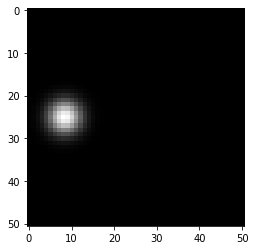

In [3]:
x,dx,ddx = spring_to_movie(x_train[:,0], dt=0.02, dim = 51)

print(x.shape)
plt.imshow(x[0], cmap = 'gray')

In [4]:
class AE(tfk.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
        #stateful metrics 
        self.total_loss_tracker = tfk.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tfk.metrics.Mean(
            name="reconstruction_loss"
        )

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
        ]

    def train_step(self, data):
        #print(data.shape)
        with tf.GradientTape() as tape:
            z = self.encoder(data) 
            reconstruction = self.decoder(z) 

            #use BCE for black and white pics 
            reconstruction_loss = tf.reduce_mean(
                    tfk.losses.binary_crossentropy(data, reconstruction)
            )
            
            total_loss = reconstruction_loss # + other terms 
            
        #de-facto 
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights)) #will need to specify an optimizer 
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
        }

In [5]:
def build_encoder(input_shape, latent_dim = 1):
    """
    i'll need to add multiple outputs for the encoding as well as derivative info(s) as outputs vae style 
    """
    encoder_inputs = tfk.Input(shape=input_shape) 
    
    #initially following parameters outlined in sindy paper 
    activation = "relu"
    x = tfk.layers.Dense(128, activation=activation, kernel_initializer = tfk.initializers.GlorotNormal(seed=seed))(encoder_inputs)
    x = tfk.layers.Dense(64, activation=activation, kernel_initializer = tfk.initializers.GlorotNormal(seed=seed))(x)
    x = tfk.layers.Dense(32, activation=activation, kernel_initializer = tfk.initializers.GlorotNormal(seed=seed))(x)
    z = tfk.layers.Dense(latent_dim, activation=activation, kernel_initializer = tfk.initializers.GlorotNormal(seed=seed))(x)

    encoder = tfk.Model(encoder_inputs, z, name="encoder")
    return encoder


def build_decoder(output_shape, latent_dim = 1):
    decoder_inputs = tfk.Input(shape=(latent_dim,))
    
    #initially following parameters outlined in sindy paper 
    activation = "relu"
    x = tfk.layers.Dense(32, activation=activation, kernel_initializer = tfk.initializers.GlorotNormal(seed=seed))(decoder_inputs)
    x = tfk.layers.Dense(64, activation=activation, kernel_initializer = tfk.initializers.GlorotNormal(seed=seed))(x)
    x = tfk.layers.Dense(128, activation=activation, kernel_initializer = tfk.initializers.GlorotNormal(seed=seed))(x)
    reconstructed = tfk.layers.Dense(output_shape, activation="sigmoid", kernel_initializer = tfk.initializers.GlorotNormal(seed=seed))(x) #softmax for grayscale 
    

    decoder = tfk.Model(decoder_inputs, reconstructed, name="decoder")
    return decoder

In [6]:
#flatten to work with network 
dim = 51
x_train = np.reshape(x, (x.shape[0], dim*dim))
x_train.shape

(1000, 2601)

In [7]:
img_dim = x_train.shape[1:]
latent_dim = 2 #same dimension as the size of our state variable for the dynamic updates 

ae = AE(build_encoder(input_shape = img_dim, latent_dim = latent_dim), 
        build_decoder(output_shape = int(np.prod(img_dim)), latent_dim = latent_dim))
ae.compile(optimizer=tfk.optimizers.Adam()) #specify the optimizer reference in class above 
ae.fit(x_train, epochs=200, batch_size=64)

Epoch 1/200
16/16 [==============================] - 1s 8ms/step - loss: 0.6808 - reconstruction_loss: 0.6539
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.2959 - reconstruction_loss: 0.1778
Epoch 3/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0618 - reconstruction_loss: 0.0564
Epoch 4/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0455 - reconstruction_loss: 0.0440
Epoch 5/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0419 - reconstruction_loss: 0.0414
Epoch 6/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0408 - reconstruction_loss: 0.0410
Epoch 7/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0408 - reconstruction_loss: 0.0407
Epoch 8/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0409 - reconstruction_loss: 0.0406
Epoch 9/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0400 - reconstruction_loss: 0.0407
Epoch 10/2

16/16 [==============================] - 0s 12ms/step - loss: 0.0280 - reconstruction_loss: 0.0279
Epoch 75/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0281 - reconstruction_loss: 0.0279
Epoch 76/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0278 - reconstruction_loss: 0.0279
Epoch 77/200
16/16 [==============================] - 0s 17ms/step - loss: 0.0279 - reconstruction_loss: 0.0279
Epoch 78/200
16/16 [==============================] - 0s 15ms/step - loss: 0.0278 - reconstruction_loss: 0.0279
Epoch 79/200
16/16 [==============================] - 0s 15ms/step - loss: 0.0280 - reconstruction_loss: 0.0279
Epoch 80/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0281 - reconstruction_loss: 0.0279
Epoch 81/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0278 - reconstruction_loss: 0.0279
Epoch 82/200
16/16 [==============================] - 0s 15ms/step - loss: 0.0278 - reconstruction_loss: 0.0278
Epoch

16/16 [==============================] - 0s 17ms/step - loss: 0.0277 - reconstruction_loss: 0.0277
Epoch 147/200
16/16 [==============================] - 0s 19ms/step - loss: 0.0277 - reconstruction_loss: 0.0277
Epoch 148/200
16/16 [==============================] - 0s 17ms/step - loss: 0.0277 - reconstruction_loss: 0.0277
Epoch 149/200
16/16 [==============================] - 0s 16ms/step - loss: 0.0277 - reconstruction_loss: 0.0277
Epoch 150/200
16/16 [==============================] - 0s 15ms/step - loss: 0.0277 - reconstruction_loss: 0.0277
Epoch 151/200
16/16 [==============================] - 0s 18ms/step - loss: 0.0277 - reconstruction_loss: 0.0277
Epoch 152/200
16/16 [==============================] - 0s 18ms/step - loss: 0.0277 - reconstruction_loss: 0.0277
Epoch 153/200
16/16 [==============================] - 0s 18ms/step - loss: 0.0277 - reconstruction_loss: 0.0277
Epoch 154/200
16/16 [==============================] - 0s 16ms/step - loss: 0.0277 - reconstruction_loss: 0.02

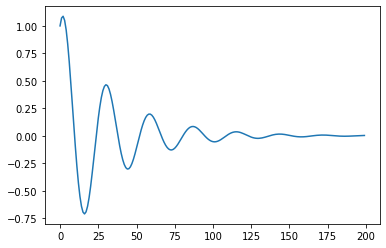

In [8]:
#generate test data and make some predictions
params = {'c':0.6, 'm':0.2, 'k':1}
x0 = [1, 1]
t = np.arange(0, 20, 0.1)

x_test = generate_spring_data(params,t,x0)


plt.plot(x_test[:,0])

In [9]:
y,_,_ = spring_to_movie(x_test[:,0], dt=0.1, dim = dim)
y.shape

(200, 51, 51)

In [10]:
y_pred = ae.decoder(ae.encoder(np.reshape(y, (y.shape[0], dim*dim))))
y_pred = np.reshape(y_pred, (y.shape[0], dim, dim))


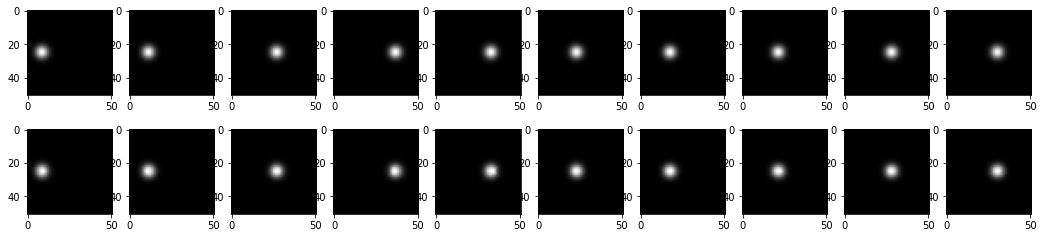

In [11]:
fig, axs = plt.subplots(2,10, figsize=(18,4))

for i in range(10):
    axs[0][i].imshow(y[i*5], cmap = "gray")
    axs[1][i].imshow(y_pred[i*5], cmap = "gray")

## An entire aside on testing the subclassed model performance on MNIST 

In [96]:
#don't need labels since self-supervised 
(x_train, _), (x_test, _) = tfk.datasets.mnist.load_data()
print(x_train.shape, x_test.shape)

#preprocess the data
x_train = x_train.astype('float32') / 255. #normalize 
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape((len(x_train), x_train[0].size))
x_test = x_test.reshape((len(x_test), x_test[0].size))
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28) (10000, 28, 28)
(60000, 784)
(10000, 784)


In [97]:
#i know this works with a specific network type 
encoding_dim = 32
dim = x_train[0].size

input_img = tfk.layers.Input(shape=(dim,), name = "input")
encoded = tfk.layers.Dense(units = encoding_dim, activation = 'relu', name = 'latent')(input_img)
decoded = tfk.layers.Dense(units = dim, activation = 'sigmoid', name = "output")(encoded)

autoencoder = tfk.Model(input_img, decoded, name = "autoencoder")
encoder = tfk.Model(input_img, encoded, name = "encoder")

#now create the decoder architecture 
encoded_input = tfk.layers.Input(shape=(encoding_dim,), name = "input") #new layer of type `Input`
decoded_output = autoencoder.layers[-1](encoded_input) #reuse the decoded layer 

decoder = tfk.Model(encoded_input, decoded_output, name = "decoder") 

In [117]:
ae = AE(build_encoder(input_shape = dim, latent_dim = encoding_dim), 
        build_decoder(output_shape = int(np.prod(dim)), latent_dim = encoding_dim))

ae.compile(optimizer=tfk.optimizers.Adam()) #specify the optimizer reference in class above 
ae.fit(x_train, epochs=10, batch_size=256)

NameError: name 'encoding_dim' is not defined

In [99]:
pred = ae.decoder(ae.encoder(x_train))
pred = np.reshape(pred, (x_train.shape[0], 28,28))


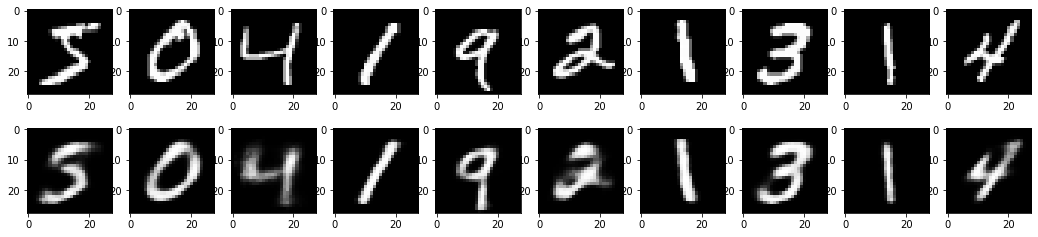

In [100]:
fig, axs = plt.subplots(2,10, figsize=(18,4))

for i in range(10):
    axs[0][i].imshow(x_train[i].reshape(28,28), cmap = "gray")
    axs[1][i].imshow(pred[i], cmap = "gray")

### aside done...

## pass derivative info through encoder and decoder 
- encoder should return the derivatives as well 

In [87]:
#shallow network 
def my_init(shape, dtype=None):
    return tf.ones(shape, dtype=dtype)

a_ = tfk.Input(shape = (1,1), name = "input")
a = tfk.layers.Dense(units = 2, kernel_initializer = my_init, activation = 'sigmoid', name = "hidden1")(a_)
a = tfk.layers.Dense(units = 2, kernel_initializer = my_init, activation = 'sigmoid', name = "hidden2")(a)
a = tfk.layers.Dense(units = 1, kernel_initializer = my_init, activation = 'sigmoid', name = "output")(a)


m = tfk.Model(a_, a, name = "simple")
m.summary()

Model: "simple"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1, 1)]            0         
                                                                 
 hidden1 (Dense)             (None, 1, 2)              4         
                                                                 
 hidden2 (Dense)             (None, 1, 2)              6         
                                                                 
 output (Dense)              (None, 1, 1)              3         
                                                                 
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


In [88]:
a = tf.constant([0.], shape = (1,1))
da = tf.constant([0.5], shape = (1,1))

In [89]:
#i hand derived this in my orange notebook somewhere for comparison

temp = a
dz = da
for i in range(len(m.weights)//2):
    weight = m.weights[2*i]
    bias = m.weights[2*i+1]

    temp = tf.matmul(temp, weight) + bias #pre-activation
    temp = tf.nn.sigmoid(temp) #activation 
    
    #dz = tf.multiply(tf.cast(temp>0, float), tf.matmul(dz, weight)) #derivative 
    dz = tf.multiply(temp*(1-temp), tf.matmul(dz, weight)) #derivative     

In [90]:
tf.nn.sigmoid(2*tf.nn.sigmoid(1.))*(1-tf.nn.sigmoid(2*tf.nn.sigmoid(1.)))*(tf.nn.sigmoid(1.)*(1-tf.nn.sigmoid(1.)))*0.5


<tf.Tensor: shape=(), dtype=float32, numpy=0.01501581>

In [91]:
dz

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.01501581]], dtype=float32)>

In [230]:
def z_derivative(model, data):
    x, dx = data #unpack 
    temp = x
    dz = dx
    for i in range(len(model.weights)//2):
        weight = model.weights[2*i]
        bias = model.weights[2*i+1]

        #add a switch case here or something for selecting the activation 

        temp = tf.matmul(temp, weight) + bias #pre-activation
        temp = tf.nn.relu(temp) #activation 

        dz = tf.multiply(tf.cast(temp>0, float), tf.matmul(dz, weight)) #derivative 
        #dz = tf.multiply(temp*(1-temp), tf.matmul(dz, weight)) #derivative

    return dz

In [231]:
sample_data = tf.constant([0,1], shape=(2,1,1), dtype=float)
sample_derivatives = tf.constant([0.5,1], shape=(2,1,1), dtype=float)

z_derivative(m, (sample_data, sample_derivatives))

<tf.Tensor: shape=(2, 1, 1), dtype=float32, numpy=
array([[[0.]],

       [[4.]]], dtype=float32)>

In [96]:
class DAE(tfk.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
        #stateful metrics 
        self.total_loss_tracker = tfk.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tfk.metrics.Mean(
            name="reconstruction_loss"
        )
        self.dx_out_loss_tracker = tfk.metrics.Mean(name="dx_out_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.dx_out_loss_tracker
        ]
    
    def z_derivative(self, model, data):
        x, dx = data #unpack 
        temp = x
        dz = dx
        for i in range(len(model.weights)//2):
            temp = tf.matmul(temp, model.weights[2*i]) + model.weights[2*i+1] #pre-activation
            temp = tf.nn.relu(temp) #activation 

            dz = tf.multiply(tf.cast(temp>0, float), tf.matmul(dz, model.weights[2*i])) #relu derivative 
            #dz = tf.multiply(temp*(1-temp), tf.matmul(dz, weight)) #sigmoid derivative

        return dz
    
    def train_step(self, data):
        print(data.shape)
        with tf.GradientTape() as tape:
            #unpacking positional and derivative information 
            x, dx = tf.unstack(data[1])  #symbolic tensors not iterable so i have to do this 
            x = x[None,:]
            dx = dx[None,:]
        
            z = self.encoder(x) 
            reconstruction = self.decoder(z) 
            
            #derivatives 
            #dz = self.z_derivative(self.encoder, (x,dx))
            #dx_out = self.z_derivative(self.decoder, (z,dz)) 
            
            #least squares regression for coef predictions 

            reconstruction_loss = tf.reduce_mean(
                    tfk.losses.binary_crossentropy(x, reconstruction)
            )
            
            
            dx_out_loss = tf.losses.MeanSquaredError()(dx, dx_out)
            
            
            total_loss = reconstruction_loss + (1e-01)*dx_out_loss
            
        #de-facto 
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights)) #will need to specify an optimizer 
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.dx_out_loss_tracker.update_state(dx_out_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "dx_out_loss": self.dx_out_loss_tracker.result(),
        }

In [69]:
#now our dataset consists of BOTH images and their derivatives
x_ = np.reshape(x, (x.shape[0], np.prod(x.shape[1:])))
dx_ = np.reshape(dx, (dx.shape[0], np.prod(dx.shape[1:])))

x_train = np.array(list(zip(x_, dx_)))

print(x_train.shape)
print(x_.shape, dx_.shape)

(1000, 2, 2601)
(1000, 2601) (1000, 2601)


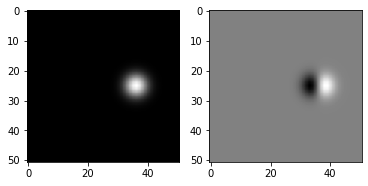

In [70]:
#baseline 
f, a = plt.subplots(1,2)
i = 100
a[0].imshow(x[i].reshape(51,51), cmap = 'gray')
a[1].imshow(dx[i].reshape(51,51), cmap = 'gray')

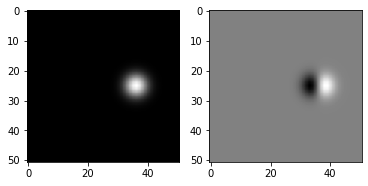

In [71]:
f, a = plt.subplots(1,2)
i = 100
a[0].imshow(x_train[i][0].reshape(51,51), cmap = 'gray')
a[1].imshow(x_train[i][1].reshape(51,51), cmap = 'gray')

In [72]:
x_.shape

(1000, 2601)

In [93]:
#ALTERNATE 
x_train = tf.data.Dataset.from_tensor_slices((x_, dx_))
x_train = x_train.shuffle(buffer_size=1024).batch(32)

In [94]:
next(iter(x_train))[0].shape

TensorShape([32, 2601])

In [97]:
tf.random.set_seed(seed)

#img_dim = x_train.shape[-1]
img_dim = 2601
latent_dim = 2

dae = DAE(build_encoder(input_shape = (img_dim, ), latent_dim = latent_dim), 
          build_decoder(output_shape = int(np.prod(img_dim)), latent_dim = latent_dim))

dae.compile(optimizer=tfk.optimizers.Adam()) #specify the optimizer reference in class above 
dae.fit(x_train, epochs=100)

Epoch 1/100
(None, 2601) (None, 2601)


TypeError: in user code:

    File "/Users/nathanielnethercott/.pyenv/versions/3.9.3/lib/python3.9/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/Users/nathanielnethercott/.pyenv/versions/3.9.3/lib/python3.9/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/nathanielnethercott/.pyenv/versions/3.9.3/lib/python3.9/site-packages/keras/engine/training.py", line 1137, in run_step  **
        with tf.control_dependencies(_minimum_control_deps(outputs)):

    TypeError: Can not convert a NoneType into a Tensor or Operation.


In [ ]:
y_pred = dae.decoder(dae.encoder(np.reshape(y, (y.shape[0], dim*dim))))
y_pred = np.reshape(y_pred, (y.shape[0], dim, dim))

fig, axs = plt.subplots(2,10, figsize=(18,4))

for i in range(10):
    axs[0][i].imshow(y[i*5], cmap = "gray")
    axs[1][i].imshow(y_pred[i*5], cmap = "gray")

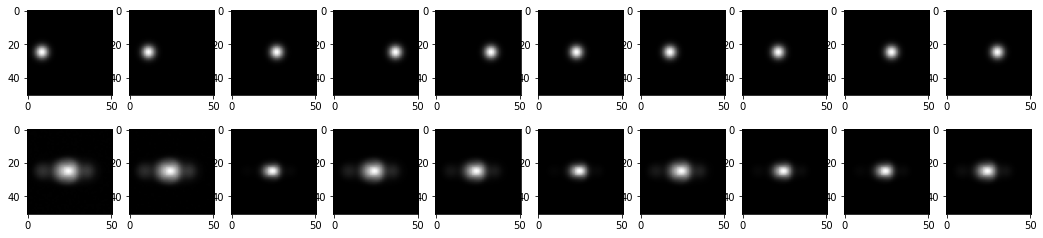

In [32]:
y_pred = dae.decoder(dae.encoder(np.reshape(y, (y.shape[0], dim*dim))))
y_pred = np.reshape(y_pred, (y.shape[0], dim, dim))

fig, axs = plt.subplots(2,10, figsize=(18,4))

for i in range(10):
    axs[0][i].imshow(y[i*5], cmap = "gray")
    axs[1][i].imshow(y_pred[i*5], cmap = "gray")

In [98]:
#train_step 
@tf.function
def train_step_(data):
    x, y = data
    return (x.shape, y.shape)
     

In [99]:
for i, e in enumerate(x_train):
    print(train_step_(e))

(<tf.Tensor: shape=(2,), dtype=int32, numpy=array([  32, 2601], dtype=int32)>, <tf.Tensor: shape=(2,), dtype=int32, numpy=array([  32, 2601], dtype=int32)>)
(<tf.Tensor: shape=(2,), dtype=int32, numpy=array([  32, 2601], dtype=int32)>, <tf.Tensor: shape=(2,), dtype=int32, numpy=array([  32, 2601], dtype=int32)>)
(<tf.Tensor: shape=(2,), dtype=int32, numpy=array([  32, 2601], dtype=int32)>, <tf.Tensor: shape=(2,), dtype=int32, numpy=array([  32, 2601], dtype=int32)>)
(<tf.Tensor: shape=(2,), dtype=int32, numpy=array([  32, 2601], dtype=int32)>, <tf.Tensor: shape=(2,), dtype=int32, numpy=array([  32, 2601], dtype=int32)>)
(<tf.Tensor: shape=(2,), dtype=int32, numpy=array([  32, 2601], dtype=int32)>, <tf.Tensor: shape=(2,), dtype=int32, numpy=array([  32, 2601], dtype=int32)>)
(<tf.Tensor: shape=(2,), dtype=int32, numpy=array([  32, 2601], dtype=int32)>, <tf.Tensor: shape=(2,), dtype=int32, numpy=array([  32, 2601], dtype=int32)>)
(<tf.Tensor: shape=(2,), dtype=int32, numpy=array([  32, 2

In [ ]:
x_trao